# 🔥 Fine-tuning RoBERTa with Pure PyTorch

---

## 📚 What You'll Learn

In this notebook, we'll fine-tune **FacebookAI/roberta-base** on the **fancyzhx/ag_news** dataset using **native PyTorch** training loops instead of HuggingFace's Trainer API. This gives you:

1. **Full Control** - Complete visibility into the training process
2. **Customization** - Easy to modify loss functions, optimizers, schedulers
3. **Understanding** - Learn what happens under the hood
4. **Flexibility** - Add custom callbacks, logging, checkpointing

---

## 🆚 Trainer API vs Pure PyTorch

| Aspect | Trainer API | Pure PyTorch |
|--------|-------------|---------------|
| Code Complexity | Low (few lines) | Higher (explicit loops) |
| Flexibility | Limited | Full control |
| Learning Curve | Easier | Steeper |
| Debugging | Harder | Easier |
| Custom Logic | Callbacks needed | Direct implementation |
| Best For | Quick prototyping | Production & research |

---

## 🛠️ Setup & Installation

In [21]:
# Install required packages (uncomment if needed)
# !pip install transformers datasets torch accelerate tqdm matplotlib scikit-learn -q

In [2]:
# Import essential libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding
)

from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.auto import tqdm
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Using Apple Silicon MPS")
else:
    device = torch.device("cpu")
    print("💻 Using CPU (training will be slower)")

print(f"\nDevice selected: {device}")

🚀 Using CUDA GPU: 
   Memory: 205.8 GB

Device selected: cuda


---

## ⚙️ Configuration

Let's define all hyperparameters in one place for easy modification.

In [4]:
# Configuration dictionary
CONFIG = {
    # Model
    "model_checkpoint": "FacebookAI/roberta-base",
    "num_labels": 4,
    
    # Training
    "epochs": 3,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "max_length": 256,
    
    # Optimization
    "use_fp16": torch.cuda.is_available(),  # Mixed precision training
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1.0,  # Gradient clipping
    
    # Logging & Saving
    "log_steps": 500,
    "save_dir": "./roberta_ag_news_pytorch",
    
    # Reproducibility
    "seed": 42
}

# Label mappings
LABEL_NAMES = {
    0: "🌍 World",
    1: "⚽ Sports",
    2: "💼 Business",
    3: "🔬 Sci/Tech"
}

ID2LABEL = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
LABEL2ID = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}

print("✅ Configuration set!")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

✅ Configuration set!
   model_checkpoint: FacebookAI/roberta-base
   num_labels: 4
   epochs: 3
   batch_size: 16
   learning_rate: 2e-05
   weight_decay: 0.01
   warmup_ratio: 0.1
   max_length: 256
   use_fp16: True
   gradient_accumulation_steps: 1
   max_grad_norm: 1.0
   log_steps: 500
   save_dir: ./roberta_ag_news_pytorch
   seed: 42


In [5]:
# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])
print(f"✅ Random seed set to {CONFIG['seed']}")

✅ Random seed set to 42


---

## 📊 Part 1: Loading & Preparing Data

In [6]:
# Load the AG News dataset
print("📦 Loading AG News dataset...")
dataset = load_dataset("fancyzhx/ag_news")

print("\n📊 Dataset Structure:")
print(dataset)
print(f"\n   Training samples: {len(dataset['train']):,}")
print(f"   Test samples: {len(dataset['test']):,}")

📦 Loading AG News dataset...

📊 Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

   Training samples: 120,000
   Test samples: 7,600


In [7]:
# Load the tokenizer
print(f"📦 Loading tokenizer: {CONFIG['model_checkpoint']}")
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_checkpoint"])

print(f"✅ Tokenizer loaded!")
print(f"   Vocabulary size: {tokenizer.vocab_size:,}")

📦 Loading tokenizer: FacebookAI/roberta-base
✅ Tokenizer loaded!
   Vocabulary size: 50,265


In [8]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=CONFIG["max_length"]
    )

# Apply tokenization
print("⏳ Tokenizing dataset...")
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)
print("✅ Tokenization complete!")
print(tokenized_dataset)

⏳ Tokenizing dataset...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})


In [9]:
# Create data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create PyTorch DataLoaders
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    collate_fn=data_collator,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False
)

eval_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=CONFIG["batch_size"] * 2,  # Larger batch for evaluation
    shuffle=False,
    collate_fn=data_collator,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ DataLoaders created!")
print(f"   Training batches: {len(train_dataloader):,}")
print(f"   Evaluation batches: {len(eval_dataloader):,}")

✅ DataLoaders created!
   Training batches: 7,500
   Evaluation batches: 238


---

## 🧠 Part 2: Loading the Model

In [10]:
# Load the model
print(f"📦 Loading model: {CONFIG['model_checkpoint']}")

model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG["model_checkpoint"],
    num_labels=CONFIG["num_labels"],
    id2label=ID2LABEL,
    label2id=LABEL2ID
)

# Move model to device
model.to(device)

print(f"\n✅ Model loaded and moved to {device}")
print(f"   Model type: {type(model).__name__}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

📦 Loading model: FacebookAI/roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model loaded and moved to cuda
   Model type: RobertaForSequenceClassification
   Total parameters: 124,648,708
   Trainable parameters: 124,648,708


---

## 🔧 Part 3: Setting Up Optimizer & Scheduler

In [11]:
# Calculate training steps
num_training_steps = len(train_dataloader) * CONFIG["epochs"]
num_warmup_steps = int(num_training_steps * CONFIG["warmup_ratio"])

print(f"📊 Training Schedule:")
print(f"   Total steps: {num_training_steps:,}")
print(f"   Warmup steps: {num_warmup_steps:,}")
print(f"   Steps per epoch: {len(train_dataloader):,}")

📊 Training Schedule:
   Total steps: 22,500
   Warmup steps: 2,250
   Steps per epoch: 7,500


In [12]:
# Separate parameters for weight decay
# Don't apply weight decay to bias and LayerNorm parameters
no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]

optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": CONFIG["weight_decay"],
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

# Create optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=CONFIG["learning_rate"],
    eps=1e-8
)

print(f"✅ Optimizer created: AdamW")
print(f"   Learning rate: {CONFIG['learning_rate']}")
print(f"   Weight decay: {CONFIG['weight_decay']}")

✅ Optimizer created: AdamW
   Learning rate: 2e-05
   Weight decay: 0.01


In [13]:
# Create learning rate scheduler with warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print(f"✅ Scheduler created: Linear warmup + decay")

✅ Scheduler created: Linear warmup + decay


In [14]:
# Create gradient scaler for mixed precision training
scaler = GradScaler() if CONFIG["use_fp16"] else None

if scaler:
    print("✅ Mixed precision training (FP16) enabled")
else:
    print("ℹ️ Training in full precision (FP32)")

✅ Mixed precision training (FP16) enabled


---

## 📐 Part 4: Define Training & Evaluation Functions

In [15]:
def train_epoch(model, dataloader, optimizer, scheduler, scaler, device, epoch):
    """
    Train the model for one epoch.
    
    Args:
        model: The model to train
        dataloader: Training data loader
        optimizer: The optimizer
        scheduler: Learning rate scheduler
        scaler: Gradient scaler for mixed precision
        device: Device to use
        epoch: Current epoch number
    
    Returns:
        Average training loss for the epoch
    """
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    
    # Progress bar
    progress_bar = tqdm(
        dataloader, 
        desc=f"Epoch {epoch + 1}/{CONFIG['epochs']} [Training]",
        leave=True
    )
    
    for step, batch in enumerate(progress_bar):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass with mixed precision
        if scaler:
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss
                loss = loss / CONFIG["gradient_accumulation_steps"]
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
        else:
            outputs = model(**batch)
            loss = outputs.loss
            loss = loss / CONFIG["gradient_accumulation_steps"]
            loss.backward()
        
        total_loss += loss.item() * CONFIG["gradient_accumulation_steps"]
        
        # Gradient accumulation
        if (step + 1) % CONFIG["gradient_accumulation_steps"] == 0:
            if scaler:
                # Unscale gradients and clip
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG["max_grad_norm"])
                
                # Update weights
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG["max_grad_norm"])
                optimizer.step()
            
            scheduler.step()
            optimizer.zero_grad()
        
        # Update progress bar
        current_lr = scheduler.get_last_lr()[0]
        progress_bar.set_postfix({
            "loss": f"{loss.item() * CONFIG['gradient_accumulation_steps']:.4f}",
            "lr": f"{current_lr:.2e}"
        })
        
        # Logging
        if (step + 1) % CONFIG["log_steps"] == 0:
            avg_loss = total_loss / (step + 1)
            print(f"\n   Step {step + 1}/{num_batches} | Avg Loss: {avg_loss:.4f} | LR: {current_lr:.2e}")
    
    return total_loss / num_batches

In [16]:
def evaluate(model, dataloader, device):
    """
    Evaluate the model on the given dataloader.
    
    Args:
        model: The model to evaluate
        dataloader: Evaluation data loader
        device: Device to use
    
    Returns:
        Dictionary with evaluation metrics
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    
    with torch.no_grad():
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            if CONFIG["use_fp16"]:
                with autocast():
                    outputs = model(**batch)
            else:
                outputs = model(**batch)
            
            total_loss += outputs.loss.item()
            
            # Get predictions
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())
    
    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    
    return {
        "loss": avg_loss,
        "accuracy": accuracy,
        "f1": f1,
        "predictions": all_predictions,
        "labels": all_labels
    }

---

## 🚀 Part 5: Training Loop

This is the main training loop - the heart of PyTorch training!

In [17]:
# Create save directory
os.makedirs(CONFIG["save_dir"], exist_ok=True)

# Training history
history = {
    "train_loss": [],
    "eval_loss": [],
    "eval_accuracy": [],
    "eval_f1": []
}

best_accuracy = 0
best_epoch = 0

print("🚀 Starting Training!")
print("=" * 70)
print(f"   Model: {CONFIG['model_checkpoint']}")
print(f"   Epochs: {CONFIG['epochs']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']}")
print(f"   Device: {device}")
print("=" * 70)

for epoch in range(CONFIG["epochs"]):
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch + 1}/{CONFIG['epochs']}")
    print(f"{'='*70}")
    
    # Training
    train_loss = train_epoch(
        model, train_dataloader, optimizer, scheduler, scaler, device, epoch
    )
    history["train_loss"].append(train_loss)
    
    # Evaluation
    print(f"\n📊 Evaluating...")
    eval_metrics = evaluate(model, eval_dataloader, device)
    
    history["eval_loss"].append(eval_metrics["loss"])
    history["eval_accuracy"].append(eval_metrics["accuracy"])
    history["eval_f1"].append(eval_metrics["f1"])
    
    # Print epoch results
    print(f"\n📈 Epoch {epoch + 1} Results:")
    print(f"   Train Loss:     {train_loss:.4f}")
    print(f"   Eval Loss:      {eval_metrics['loss']:.4f}")
    print(f"   Eval Accuracy:  {eval_metrics['accuracy']:.4f} ({eval_metrics['accuracy']*100:.2f}%)")
    print(f"   Eval F1 Score:  {eval_metrics['f1']:.4f}")
    
    # Save best model
    if eval_metrics["accuracy"] > best_accuracy:
        best_accuracy = eval_metrics["accuracy"]
        best_epoch = epoch + 1
        
        # Save model
        best_model_path = os.path.join(CONFIG["save_dir"], "best_model")
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"   ✅ New best model saved! (Accuracy: {best_accuracy:.4f})")
    
    # Save checkpoint
    checkpoint_path = os.path.join(CONFIG["save_dir"], f"checkpoint-epoch-{epoch + 1}")
    model.save_pretrained(checkpoint_path)

print("\n" + "=" * 70)
print("✅ Training Complete!")
print(f"   Best Epoch: {best_epoch}")
print(f"   Best Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print("=" * 70)

🚀 Starting Training!
   Model: FacebookAI/roberta-base
   Epochs: 3
   Batch size: 16
   Learning rate: 2e-05
   Device: cuda

EPOCH 1/3


Epoch 1/3 [Training]:   0%|          | 0/7500 [00:00<?, ?it/s]


   Step 500/7500 | Avg Loss: 0.9488 | LR: 4.44e-06

   Step 1000/7500 | Avg Loss: 0.6318 | LR: 8.89e-06

   Step 1500/7500 | Avg Loss: 0.5196 | LR: 1.33e-05

   Step 2000/7500 | Avg Loss: 0.4550 | LR: 1.78e-05

   Step 2500/7500 | Avg Loss: 0.4138 | LR: 1.98e-05

   Step 3000/7500 | Avg Loss: 0.3878 | LR: 1.93e-05

   Step 3500/7500 | Avg Loss: 0.3676 | LR: 1.88e-05

   Step 4000/7500 | Avg Loss: 0.3510 | LR: 1.83e-05

   Step 4500/7500 | Avg Loss: 0.3381 | LR: 1.78e-05

   Step 5000/7500 | Avg Loss: 0.3261 | LR: 1.73e-05

   Step 5500/7500 | Avg Loss: 0.3164 | LR: 1.68e-05

   Step 6000/7500 | Avg Loss: 0.3088 | LR: 1.63e-05

   Step 6500/7500 | Avg Loss: 0.3005 | LR: 1.58e-05

   Step 7000/7500 | Avg Loss: 0.2930 | LR: 1.53e-05

   Step 7500/7500 | Avg Loss: 0.2869 | LR: 1.48e-05

📊 Evaluating...


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


📈 Epoch 1 Results:
   Train Loss:     0.2869
   Eval Loss:      0.1852
   Eval Accuracy:  0.9425 (94.25%)
   Eval F1 Score:  0.9425
   ✅ New best model saved! (Accuracy: 0.9425)

EPOCH 2/3


Epoch 2/3 [Training]:   0%|          | 0/7500 [00:00<?, ?it/s]


   Step 500/7500 | Avg Loss: 0.1621 | LR: 1.43e-05

   Step 1000/7500 | Avg Loss: 0.1701 | LR: 1.38e-05

   Step 1500/7500 | Avg Loss: 0.1698 | LR: 1.33e-05

   Step 2000/7500 | Avg Loss: 0.1727 | LR: 1.28e-05

   Step 2500/7500 | Avg Loss: 0.1710 | LR: 1.23e-05

   Step 3000/7500 | Avg Loss: 0.1696 | LR: 1.19e-05

   Step 3500/7500 | Avg Loss: 0.1701 | LR: 1.14e-05

   Step 4000/7500 | Avg Loss: 0.1692 | LR: 1.09e-05

   Step 4500/7500 | Avg Loss: 0.1692 | LR: 1.04e-05

   Step 5000/7500 | Avg Loss: 0.1679 | LR: 9.88e-06

   Step 5500/7500 | Avg Loss: 0.1676 | LR: 9.38e-06

   Step 6000/7500 | Avg Loss: 0.1669 | LR: 8.89e-06

   Step 6500/7500 | Avg Loss: 0.1655 | LR: 8.40e-06

   Step 7000/7500 | Avg Loss: 0.1655 | LR: 7.90e-06

   Step 7500/7500 | Avg Loss: 0.1649 | LR: 7.41e-06

📊 Evaluating...


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


📈 Epoch 2 Results:
   Train Loss:     0.1649
   Eval Loss:      0.1868
   Eval Accuracy:  0.9508 (95.08%)
   Eval F1 Score:  0.9508
   ✅ New best model saved! (Accuracy: 0.9508)

EPOCH 3/3


Epoch 3/3 [Training]:   0%|          | 0/7500 [00:00<?, ?it/s]


   Step 500/7500 | Avg Loss: 0.1170 | LR: 6.91e-06

   Step 1000/7500 | Avg Loss: 0.1183 | LR: 6.42e-06

   Step 1500/7500 | Avg Loss: 0.1210 | LR: 5.93e-06

   Step 2000/7500 | Avg Loss: 0.1218 | LR: 5.43e-06

   Step 2500/7500 | Avg Loss: 0.1221 | LR: 4.94e-06

   Step 3000/7500 | Avg Loss: 0.1202 | LR: 4.44e-06

   Step 3500/7500 | Avg Loss: 0.1221 | LR: 3.95e-06

   Step 4000/7500 | Avg Loss: 0.1216 | LR: 3.46e-06

   Step 4500/7500 | Avg Loss: 0.1207 | LR: 2.96e-06

   Step 5000/7500 | Avg Loss: 0.1209 | LR: 2.47e-06

   Step 5500/7500 | Avg Loss: 0.1200 | LR: 1.98e-06

   Step 6000/7500 | Avg Loss: 0.1193 | LR: 1.48e-06

   Step 6500/7500 | Avg Loss: 0.1194 | LR: 9.88e-07

   Step 7000/7500 | Avg Loss: 0.1190 | LR: 4.94e-07

   Step 7500/7500 | Avg Loss: 0.1185 | LR: 0.00e+00

📊 Evaluating...


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


📈 Epoch 3 Results:
   Train Loss:     0.1185
   Eval Loss:      0.2072
   Eval Accuracy:  0.9517 (95.17%)
   Eval F1 Score:  0.9517
   ✅ New best model saved! (Accuracy: 0.9517)

✅ Training Complete!
   Best Epoch: 3
   Best Accuracy: 0.9517 (95.17%)


---

## 📊 Part 6: Visualize Training History

In [18]:
# Display training history as a table
print("\n📊 Training History:")
print("=" * 70)
print(f"{'Epoch':<10} {'Train Loss':<15} {'Eval Loss':<15} {'Accuracy':<15} {'F1 Score':<15}")
print("-" * 70)

for i in range(CONFIG["epochs"]):
    print(f"{i+1:<10} {history['train_loss'][i]:<15.4f} {history['eval_loss'][i]:<15.4f} "
          f"{history['eval_accuracy'][i]:<15.4f} {history['eval_f1'][i]:<15.4f}")

print("=" * 70)


📊 Training History:
Epoch      Train Loss      Eval Loss       Accuracy        F1 Score       
----------------------------------------------------------------------
1          0.2869          0.1852          0.9425          0.9425         
2          0.1649          0.1868          0.9508          0.9508         
3          0.1185          0.2072          0.9517          0.9517         


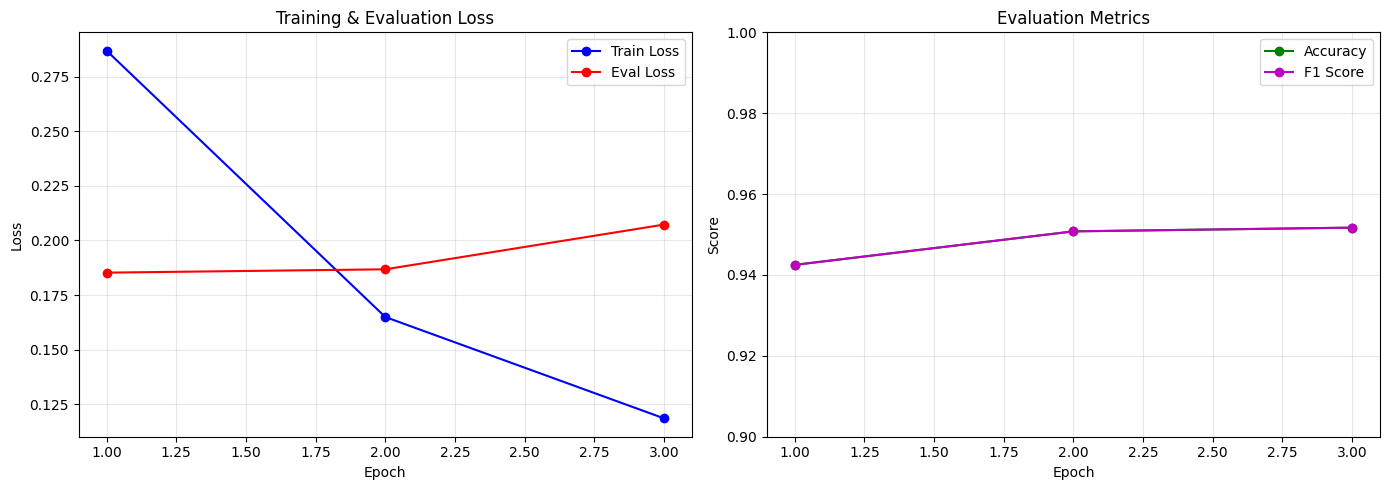

✅ Training history plot saved!


In [22]:
# Try to plot if matplotlib is available
try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    axes[0].plot(range(1, CONFIG["epochs"] + 1), history["train_loss"], 'b-o', label="Train Loss")
    axes[0].plot(range(1, CONFIG["epochs"] + 1), history["eval_loss"], 'r-o', label="Eval Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training & Evaluation Loss")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(range(1, CONFIG["epochs"] + 1), history["eval_accuracy"], 'g-o', label="Accuracy")
    axes[1].plot(range(1, CONFIG["epochs"] + 1), history["eval_f1"], 'm-o', label="F1 Score")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].set_title("Evaluation Metrics")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0.9, 1.0])  # Zoom in on high accuracy range
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG["save_dir"], "training_history.png"), dpi=150)
    plt.show()
    print("✅ Training history plot saved!")
    
except ImportError:
    print("ℹ️ matplotlib not available - skipping plots")

---

## 📋 Part 7: Detailed Classification Report

In [23]:
# Load best model and evaluate
print("📦 Loading best model for final evaluation...")
best_model_path = os.path.join(CONFIG["save_dir"], "best_model")

best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
best_model.to(device)

# Final evaluation
final_metrics = evaluate(best_model, eval_dataloader, device)

# Classification report
print("\n📊 Detailed Classification Report:")
print("=" * 70)
target_names = [ID2LABEL[i] for i in range(4)]
report = classification_report(
    final_metrics["labels"], 
    final_metrics["predictions"],
    target_names=target_names,
    digits=4
)
print(report)

📦 Loading best model for final evaluation...


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


📊 Detailed Classification Report:
              precision    recall  f1-score   support

       World     0.9650    0.9584    0.9617      1900
      Sports     0.9905    0.9911    0.9908      1900
    Business     0.9366    0.9089    0.9225      1900
    Sci/Tech     0.9157    0.9484    0.9317      1900

    accuracy                         0.9517      7600
   macro avg     0.9519    0.9517    0.9517      7600
weighted avg     0.9519    0.9517    0.9517      7600



---

## 🔮 Part 8: Inference

In [24]:
def predict(text, model, tokenizer, device):
    """
    Predict the news category for a given text.
    
    Args:
        text: Input text to classify
        model: The trained model
        tokenizer: The tokenizer
        device: Device to use
    
    Returns:
        Dictionary with prediction results
    """
    model.eval()
    
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=CONFIG["max_length"],
        padding=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return {
        "topic": LABEL_NAMES[predicted_class],
        "topic_id": predicted_class,
        "confidence": confidence,
        "all_probabilities": {
            LABEL_NAMES[i]: f"{prob:.2%}"
            for i, prob in enumerate(probabilities[0].cpu().numpy())
        }
    }

In [25]:
# Test predictions
test_headlines = [
    "UN Security Council holds emergency meeting to discuss rising tensions in Eastern Europe.",
    "Manchester City wins Champions League after dramatic penalty shootout.",
    "Apple stock surges 10% after announcing record iPhone sales.",
    "NASA's new telescope captures stunning images of distant galaxies.",
    "Federal Reserve announces interest rate decision amid inflation concerns.",
    "Scientists develop breakthrough AI system that can predict earthquakes."
]

print("🗞️ News Classification Results (PyTorch Model)")
print("=" * 70)

for i, headline in enumerate(test_headlines, 1):
    result = predict(headline, best_model, tokenizer, device)
    print(f"\n📰 Article {i}:")
    print(f"   \"{headline[:70]}...\"" if len(headline) > 70 else f"   \"{headline}\"")
    print(f"   → Predicted: {result['topic']}")
    print(f"   → Confidence: {result['confidence']:.2%}")

🗞️ News Classification Results (PyTorch Model)

📰 Article 1:
   "UN Security Council holds emergency meeting to discuss rising tensions..."
   → Predicted: 🌍 World
   → Confidence: 99.91%

📰 Article 2:
   "Manchester City wins Champions League after dramatic penalty shootout."
   → Predicted: 🌍 World
   → Confidence: 99.91%

📰 Article 3:
   "Apple stock surges 10% after announcing record iPhone sales."
   → Predicted: 🔬 Sci/Tech
   → Confidence: 87.80%

📰 Article 4:
   "NASA's new telescope captures stunning images of distant galaxies."
   → Predicted: 🔬 Sci/Tech
   → Confidence: 98.18%

📰 Article 5:
   "Federal Reserve announces interest rate decision amid inflation concer..."
   → Predicted: 💼 Business
   → Confidence: 98.66%

📰 Article 6:
   "Scientists develop breakthrough AI system that can predict earthquakes..."
   → Predicted: 🔬 Sci/Tech
   → Confidence: 96.87%


In [26]:
# Detailed prediction analysis
sample_text = "Google announces new quantum computing breakthrough that could revolutionize cryptography."

result = predict(sample_text, best_model, tokenizer, device)

print("🔍 Detailed Prediction Analysis")
print("=" * 60)
print(f"\nText: {sample_text}")
print(f"\n📊 Predicted Topic: {result['topic']}")
print(f"\n📈 Probability Distribution:")

for topic, prob in result['all_probabilities'].items():
    bar_length = int(float(prob.strip('%')) / 5)
    bar = "█" * bar_length
    print(f"   {topic}: {prob} {bar}")

🔍 Detailed Prediction Analysis

Text: Google announces new quantum computing breakthrough that could revolutionize cryptography.

📊 Predicted Topic: 🔬 Sci/Tech

📈 Probability Distribution:
   🌍 World: 0.32% 
   ⚽ Sports: 0.00% 
   💼 Business: 0.46% 
   🔬 Sci/Tech: 99.22% ███████████████████


---

## 💾 Part 9: Save Final Model

In [27]:
# Save final model
final_save_path = os.path.join(CONFIG["save_dir"], "final")
os.makedirs(final_save_path, exist_ok=True)

best_model.save_pretrained(final_save_path)
tokenizer.save_pretrained(final_save_path)

# Save training config
import json
config_path = os.path.join(final_save_path, "training_config.json")
with open(config_path, "w") as f:
    json.dump(CONFIG, f, indent=2)

# Save training history
history_path = os.path.join(final_save_path, "training_history.json")
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

print(f"✅ Model and artifacts saved to: {final_save_path}")
print(f"   - model files")
print(f"   - tokenizer files")
print(f"   - training_config.json")
print(f"   - training_history.json")

✅ Model and artifacts saved to: ./roberta_ag_news_pytorch/final
   - model files
   - tokenizer files
   - training_config.json
   - training_history.json


---

## 🎓 Key Takeaways

### What We Built:

1. **Complete PyTorch training pipeline** with:
   - Custom training loop with progress bars
   - Mixed precision training (FP16)
   - Gradient clipping
   - Learning rate warmup & scheduling
   - Gradient accumulation support

2. **Proper evaluation** with:
   - Accuracy and F1 score metrics
   - Detailed classification report
   - Per-class analysis

3. **Model management** with:
   - Best model checkpointing
   - Training history saving
   - Config preservation

### PyTorch Training Loop Components:

```python
# Typical PyTorch training pattern
model.train()
for batch in dataloader:
    optimizer.zero_grad()           # Clear gradients
    outputs = model(**batch)         # Forward pass
    loss = outputs.loss             # Get loss
    loss.backward()                 # Backward pass
    optimizer.step()                # Update weights
    scheduler.step()                # Update learning rate
```

### When to Use Pure PyTorch:

- ✅ Need custom loss functions
- ✅ Complex training logic (multi-task, adversarial, etc.)
- ✅ Research experiments
- ✅ Learning and education
- ✅ Full debugging control

---

## 📚 References & Resources

- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
- [AdamW Optimizer Paper](https://arxiv.org/abs/1711.05101)
- [Mixed Precision Training](https://pytorch.org/docs/stable/amp.html)
- [Learning Rate Schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- [Gradient Clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)

---